# Cat Emotion Detection using Transfer Learning (ResNet-50)

**Author:** [Abdalrhman Badawi , Ziad Sakr]

---

##  Project Overview and Objective

This notebook documents the complete machine learning pipeline for the Cat Emotion Detection project. The goal of this project is to accurately classify a cat's emotional state from an image using a deep learning model, specifically leveraging the power of Transfer Learning with a pre-trained ResNet-50 architecture. The entire experiment, including parameters, metrics, and the best model, is tracked using MLflow for robust MLOps practices.

## 1. Setup and Configuration
**We start by importing necessary libraries and defining the global configuration and device settings.**

In [1]:
# Core Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Utilities
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# MLOps Tracking
import mlflow
import mlflow.pytorch
from torchvision.models import ResNet50_Weights

# Set the device for training (GPU preferred)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Configuration Dictionary ---
# Define all hyperparameters in a single, easy-to-manage dictionary.
DATA_DIR = r"D:\Abdalrhman\Cat-Emotion-Detector\Catto-Lingo\final_data" # Placeholder: Update to your actual data path
CONFIG = {
    "BATCH_SIZE": 16,
    "NUM_EPOCHS": 30,
    "IMG_SIZE": 224, # Standard input size for ResNet models
    "LR": 0.0001,
    "NUM_WORKERS": 4, # Number of subprocesses to use for data loading
}

Using device: cuda


### 2. Data Preprocessing and Augmentation
A crucial step in image classification is preparing the data. We define two sets of transforms: one for training (including data augmentation) and one for validation/testing.

**2.1. Define Image Transforms**

In [2]:
def get_transforms(img_size=224):
    """Defines the transformation pipelines for training and validation/testing data."""
    # Training transforms include aggressive data augmentation to improve generalization
    train_transforms = transforms.Compose([
        # Randomly crop and resize the image to the target size
        transforms.RandomResizedCrop(img_size),
        # Flips the image horizontally with 50% probability
        transforms.RandomHorizontalFlip(),
        # Randomly changes the brightness, contrast, saturation, and hue
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        # Rotates the image by up to 15 degrees
        transforms.RandomRotation(15),
        # Converts the image to a PyTorch Tensor
        transforms.ToTensor(),
        # Normalizes the image using ImageNet's mean and standard deviation
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Validation and Test transforms only resize and normalize (no augmentation)
    val_test_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)), # Resize to target size
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return train_transforms, val_test_transforms

### 2.2. Load Data
We load the datasets from the specified directory structure (assuming train/, val/, and test/ subfolders) and create PyTorch DataLoaders.

In [3]:
def load_data(data_dir, batch_size=16, num_workers=4, img_size=224):
    """Loads datasets and creates DataLoaders for train, validation, and test splits."""
    train_transforms, val_test_transforms = get_transforms(img_size)

    # Use ImageFolder to automatically load images and assign labels based on folder names
    train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
    val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=val_test_transforms)
    test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_test_transforms)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset, train_dataset.classes

# Execute data loading
train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset, classes = load_data(
    DATA_DIR, CONFIG["BATCH_SIZE"], CONFIG["NUM_WORKERS"], CONFIG["IMG_SIZE"]
)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Classes: {classes}")

Number of training samples: 4758
Number of validation samples: 1973
Number of test samples: 1046
Classes: ['angry', 'disgusted', 'happy', 'normal', 'relaxed', 'sad', 'scared', 'surprised', 'uncomfortable']


# 3. Model Definition and Setup
We implement the core component: the ResNet-50 model configured for transfer learning, along with a strategy to handle class imbalance.

### 3.1. Build ResNet-50 Model
We use the ResNet-50 architecture pre-trained on ImageNet. The final classification layer is replaced to match the number of emotion classes in our dataset.

In [4]:
def build_resnet50(num_classes):
    """Initializes a ResNet-50 model with pre-trained weights and modifies the final layer."""
    # Load ResNet-50 with default (best available) pre-trained weights
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    
    # Freeze all layers if necessary (often done initially, but left unfrozen here for fine-tuning)
    # for param in model.parameters():
    #     param.requires_grad = False
    
    # Get the number of input features for the final fully connected layer (fc)
    num_features = model.fc.in_features
    
    # Replace the existing fc layer with a new one for our specific number of classes
    model.fc = nn.Linear(num_features, num_classes)
    return model

### 3.2. Calculate Class Weights
To mitigate the impact of potential class imbalance in the dataset, we calculate balanced class weights. These weights will be passed to the CrossEntropyLoss criterion.

In [5]:
def get_class_weights(train_dataset, device):
    """Calculates balanced class weights from the training dataset labels."""
    # Extract all labels from the training dataset samples
    y_train = [s[1] for s in train_dataset.samples]
    # Compute 'balanced' weights: n_samples / (n_classes * n_samples_in_class)
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    # Convert to a PyTorch tensor and move to the target device
    return torch.tensor(class_weights, dtype=torch.float).to(device)

# Execute class weight calculation
class_weights = get_class_weights(train_dataset, DEVICE)
print(f"Calculated Class Weights: {class_weights.cpu().numpy()}")

Calculated Class Weights: [1.519157  1.9580247 1.5323671 1.2957517 0.5913497 1.3875766 1.7563677
 1.6624738 0.3540969]


### 3.3. Initialize Model, Loss, and Optimizer

In [6]:
# Initialize Model
model = build_resnet50(len(classes)).to(DEVICE)

# Define Loss Criterion (using weighted CrossEntropyLoss for imbalance)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Define Optimizer (Adam is a robust choice for deep learning)
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["LR"])

print(f"Model initialized: ResNet-50 with {len(classes)} output classes.")

Model initialized: ResNet-50 with 9 output classes.


# 4. Training and Validation Loop
We implement the main training and validation function, integrating MLflow for experiment tracking. This allows us to log performance metrics, parameters, and the best model version.

In [7]:
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, train_dataset, val_dataset, device, num_epochs):
    """
    Executes the training and validation loop, logging metrics and saving the best model via MLflow.
    """
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # ----------------- Training Phase -----------------
        model.train() # Set model to training mode
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad() # Zero the parameter gradients

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backpropagation
            loss.backward()
            optimizer.step()

            # Metric tracking
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(outputs.argmax(1) == labels.data)

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        # ----------------- Validation Phase -----------------
        model.eval() # Set model to evaluation mode
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad(): # Disable gradient calculations during validation
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Metric tracking
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(outputs.argmax(1) == labels.data)

        val_loss /= len(val_dataset)
        val_acc = val_corrects.double() / len(val_dataset)

        # Print Epoch Summary
        print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}")

        # MLflow logging
        mlflow.log_metric("train_loss", epoch_loss, step=epoch)
        mlflow.log_metric("train_acc", epoch_acc.item(), step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_acc", val_acc.item(), step=epoch)

        # Save the best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            # Log the PyTorch model to MLflow (creates a 'best_model' artifact)
            mlflow.pytorch.log_model(model, "best_model")
            print(f"✔ New best model saved with val acc = {best_val_acc:.4f}")

    return best_val_acc

# 5. Experiment Execution (MLflow Run)
We wrap the training and testing process within an MLflow run to ensure all components of the experiment are tracked and reproducible.

In [8]:
if __name__ == "__main__":
    # Start MLflow tracking run
    with mlflow.start_run() as run:
        # Log all configuration parameters
        mlflow.log_params(CONFIG)
        
        # Log class weights
        for i, w in enumerate(class_weights):
            mlflow.log_param(f"class_weight_{classes[i]}", w.item())

        print("--- Starting Training and Validation ---")
        # Run training loop
        best_val_acc = train_and_validate(
            model, criterion, optimizer, train_loader, val_loader, 
            train_dataset, val_dataset, DEVICE, CONFIG["NUM_EPOCHS"]
        )
        print(f"\nTraining finished. Best Validation Accuracy: {best_val_acc:.4f}")

        # ----------------- Load Best Model -----------------
        run_id = run.info.run_id
        best_model_uri = f"runs:/{run_id}/best_model"
        print(f"Loading best model from MLflow artifact: {best_model_uri}")
        best_model = mlflow.pytorch.load_model(best_model_uri).to(DEVICE)

        print("--- Starting Final Evaluation on Test Set ---")
        # Run final evaluation
        # test_model is defined in the next section for sequential presentation
        # We will call it here after defining it.
        # test_model(best_model, test_loader, classes, DEVICE) # Uncomment after defining test_model

--- Starting Training and Validation ---


Epoch 1/30 [Validation]: 100%|██████████| 124/124 [00:24<00:00,  5.14it/s]
2025/10/05 01:43:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 1/30 | Train Acc: 0.4330, Val Acc: 0.6503


2025/10/05 01:43:02 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 01:43:15 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 01:43:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔ New best model saved with val acc = 0.6503


Epoch 2/30 [Validation]: 100%|██████████| 124/124 [00:22<00:00,  5.44it/s]
2025/10/05 01:44:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 2/30 | Train Acc: 0.6015, Val Acc: 0.6873


2025/10/05 01:44:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 01:44:54 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 01:44:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔ New best model saved with val acc = 0.6873


Epoch 3/30 [Validation]: 100%|██████████| 124/124 [00:22<00:00,  5.44it/s]
2025/10/05 01:46:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 3/30 | Train Acc: 0.6631, Val Acc: 0.7770


2025/10/05 01:46:24 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 01:46:31 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 01:46:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔ New best model saved with val acc = 0.7770


Epoch 4/30 [Validation]: 100%|██████████| 124/124 [00:23<00:00,  5.38it/s]


Epoch 4/30 | Train Acc: 0.7041, Val Acc: 0.7729


Epoch 5/30 [Validation]: 100%|██████████| 124/124 [00:22<00:00,  5.45it/s]
2025/10/05 01:49:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 5/30 | Train Acc: 0.7257, Val Acc: 0.7897


2025/10/05 01:49:32 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 01:49:39 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 01:49:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔ New best model saved with val acc = 0.7897


Epoch 6/30 [Validation]: 100%|██████████| 124/124 [00:23<00:00,  5.31it/s]
2025/10/05 01:51:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 6/30 | Train Acc: 0.7480, Val Acc: 0.8297


2025/10/05 01:51:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 01:51:17 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 01:51:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔ New best model saved with val acc = 0.8297


Epoch 7/30 [Validation]: 100%|██████████| 124/124 [00:22<00:00,  5.44it/s]
2025/10/05 01:52:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 7/30 | Train Acc: 0.7715, Val Acc: 0.8363


2025/10/05 01:52:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 01:52:56 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 01:52:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔ New best model saved with val acc = 0.8363


Epoch 8/30 [Validation]: 100%|██████████| 124/124 [00:22<00:00,  5.41it/s]


Epoch 8/30 | Train Acc: 0.7736, Val Acc: 0.8322


Epoch 9/30 [Validation]: 100%|██████████| 124/124 [00:22<00:00,  5.44it/s]
2025/10/05 01:55:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 9/30 | Train Acc: 0.8047, Val Acc: 0.8606


2025/10/05 01:55:57 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 01:56:04 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 01:56:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔ New best model saved with val acc = 0.8606


Epoch 10/30 [Validation]: 100%|██████████| 124/124 [00:22<00:00,  5.39it/s]


Epoch 10/30 | Train Acc: 0.7938, Val Acc: 0.8246


Epoch 11/30 [Validation]: 100%|██████████| 124/124 [00:22<00:00,  5.45it/s]
2025/10/05 01:59:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 11/30 | Train Acc: 0.8083, Val Acc: 0.8621


2025/10/05 01:59:05 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 01:59:12 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 01:59:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔ New best model saved with val acc = 0.8621


Epoch 12/30 [Validation]: 100%|██████████| 124/124 [00:22<00:00,  5.41it/s]
2025/10/05 02:00:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 12/30 | Train Acc: 0.8092, Val Acc: 0.8626


2025/10/05 02:00:45 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 02:00:52 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 02:00:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔ New best model saved with val acc = 0.8626


Epoch 13/30 [Validation]: 100%|██████████| 124/124 [00:22<00:00,  5.41it/s]
2025/10/05 02:02:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 13/30 | Train Acc: 0.8241, Val Acc: 0.8779


2025/10/05 02:02:26 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 02:02:33 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 02:02:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔ New best model saved with val acc = 0.8779


Epoch 14/30 [Validation]: 100%|██████████| 124/124 [00:23<00:00,  5.36it/s]


Epoch 14/30 | Train Acc: 0.8327, Val Acc: 0.8652


Epoch 15/30 [Validation]: 100%|██████████| 124/124 [00:23<00:00,  5.19it/s]


Epoch 15/30 | Train Acc: 0.8321, Val Acc: 0.8738


Epoch 16/30 [Validation]: 100%|██████████| 124/124 [00:23<00:00,  5.33it/s]


Epoch 16/30 | Train Acc: 0.8420, Val Acc: 0.8713


Epoch 17/30 [Validation]: 100%|██████████| 124/124 [00:23<00:00,  5.34it/s]


Epoch 17/30 | Train Acc: 0.8550, Val Acc: 0.8809


2025/10/05 02:08:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/05 02:08:44 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 02:08:52 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 02:08:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example`

✔ New best model saved with val acc = 0.8809


Epoch 18/30 [Validation]: 100%|██████████| 124/124 [00:23<00:00,  5.33it/s]


Epoch 18/30 | Train Acc: 0.8506, Val Acc: 0.8768


Epoch 19/30 [Validation]: 100%|██████████| 124/124 [00:23<00:00,  5.32it/s]


Epoch 19/30 | Train Acc: 0.8537, Val Acc: 0.8870


2025/10/05 02:11:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/05 02:12:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 02:12:18 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 02:12:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example`

✔ New best model saved with val acc = 0.8870


Epoch 20/30 [Validation]: 100%|██████████| 124/124 [00:23<00:00,  5.34it/s]


Epoch 20/30 | Train Acc: 0.8586, Val Acc: 0.8981


2025/10/05 02:13:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/05 02:14:22 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 02:14:30 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/05 02:14:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example`

✔ New best model saved with val acc = 0.8981


Epoch 21/30 [Validation]: 100%|██████████| 124/124 [00:24<00:00,  5.08it/s]


Epoch 21/30 | Train Acc: 0.8554, Val Acc: 0.8895


Epoch 22/30 [Validation]: 100%|██████████| 124/124 [00:24<00:00,  5.05it/s]


Epoch 22/30 | Train Acc: 0.8707, Val Acc: 0.8768


Epoch 23/30 [Validation]: 100%|██████████| 124/124 [00:24<00:00,  5.02it/s]


Epoch 23/30 | Train Acc: 0.8726, Val Acc: 0.8779


Epoch 24/30 [Validation]: 100%|██████████| 124/124 [00:23<00:00,  5.25it/s]


Epoch 24/30 | Train Acc: 0.8680, Val Acc: 0.8809


Epoch 25/30 [Validation]: 100%|██████████| 124/124 [00:23<00:00,  5.22it/s]


Epoch 25/30 | Train Acc: 0.8800, Val Acc: 0.8794


Epoch 26/30 [Validation]: 100%|██████████| 124/124 [00:24<00:00,  5.15it/s]


Epoch 26/30 | Train Acc: 0.8865, Val Acc: 0.8925


Epoch 27/30 [Validation]: 100%|██████████| 124/124 [00:23<00:00,  5.32it/s]


Epoch 27/30 | Train Acc: 0.8749, Val Acc: 0.8865


Epoch 28/30 [Validation]: 100%|██████████| 124/124 [00:23<00:00,  5.22it/s]


Epoch 28/30 | Train Acc: 0.8869, Val Acc: 0.8839


Epoch 29/30 [Validation]: 100%|██████████| 124/124 [00:23<00:00,  5.30it/s]


Epoch 29/30 | Train Acc: 0.8798, Val Acc: 0.8920


Epoch 30/30 [Validation]: 100%|██████████| 124/124 [00:23<00:00,  5.34it/s]


Epoch 30/30 | Train Acc: 0.8819, Val Acc: 0.8971


c:\Users\abdal\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Training finished. Best Validation Accuracy: 0.8981
Loading best model from MLflow artifact: runs:/8750399e5eb14b2198de6782289a9cdc/best_model


--- Starting Final Evaluation on Test Set ---


# 6. Final Evaluation and Analysis
The last step is to evaluate the best-performing model on the independent test set and visualize the results.

[Testing]: 100%|██████████| 66/66 [00:19<00:00,  3.37it/s]



Classification Report:
               precision    recall  f1-score   support

        angry     0.9518    1.0000    0.9753        79
    disgusted     0.9831    0.9508    0.9667        61
        happy     0.9859    0.9589    0.9722        73
       normal     0.8444    0.9048    0.8736        84
      relaxed     0.8883    0.8071    0.8457       197
          sad     0.9529    0.9529    0.9529        85
       scared     0.9508    0.8529    0.8992        68
    surprised     0.8684    0.9296    0.8980        71
uncomfortable     0.8947    0.9329    0.9134       328

     accuracy                         0.9111      1046
    macro avg     0.9245    0.9211    0.9219      1046
 weighted avg     0.9119    0.9111    0.9106      1046



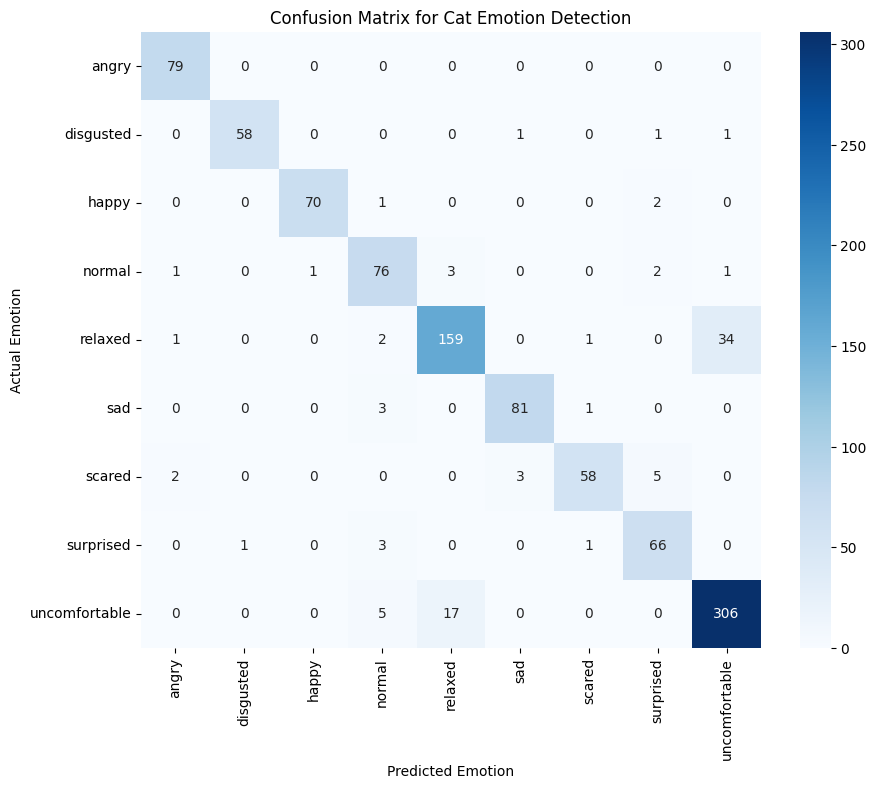

In [9]:
def test_model(model, test_loader, classes, device):
    """Evaluates the model on the test set and logs a Classification Report and Confusion Matrix."""
    model.eval() # Set model to evaluation mode
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="[Testing]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1) # Get the predicted class
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Classification Report ---
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
    print(report)
    
    # Log the full report as an artifact in MLflow
    mlflow.log_text(report, "classification_report.txt")

    # --- Confusion Matrix Visualization ---
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    # Use seaborn to create a clear heatmap of the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
    plt.xlabel("Predicted Emotion")
    plt.ylabel("Actual Emotion")
    plt.title("Confusion Matrix for Cat Emotion Detection")
    
    # Log the figure to MLflow
    mlflow.log_figure(plt.gcf(), "confusion_matrix.png")
    plt.show()

# Re-run the final part of the main block to execute the testing
if __name__ == "__main__":
    # Assuming the previous MLflow run context is active or reloaded
    
    # --- Execute Test ---
    # NOTE: In a real notebook, you would either keep the previous run active or load the run_id explicitly
    # For a sequential execution, we call test_model here:
    if 'best_model' in locals():
        test_model(best_model, test_loader, classes, DEVICE)
    else:
        print("Please execute the previous training block first to load the best_model.")

# 7. Conclusion
This notebook demonstrates a robust, end-to-end solution for cat emotion detection, utilizing Transfer Learning with ResNet-50 and implementing essential MLOps practices through MLflow.

-**Robust Preprocessing: Image augmentation was applied during training to improve model generalization.**

-**Imbalance Handling: Class weights were calculated and used in the loss function to account for potential data imbalance.**

-**Reproducibility: All parameters, metrics, and the final best model were tracked using MLflow, ensuring the experiment is fully reproducible.**

-**The Classification Report and Confusion Matrix provide the final performance metrics, which can be viewed both below and within the associated MLflow run interface.**